<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [ ]:
# Indeed url
city = 'Chattanooga'
state = 'TN'
keywords = 'data+science'
indeed = 'https://www.indeed.com/jobs?q={keywords}&l={city}%2C+{state}'

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [75]:
data = pd.read_csv('data/job_listings.csv')
data.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


## 2) Use Spacy to tokenize / clean the listings 

In [76]:
# Drop Unnamed column
data = data.drop(columns='Unnamed: 0')

In [79]:
from bs4 import BeautifulSoup

# Remove html tags and newline sequences
data['description'] = data['description'].apply(lambda x: BeautifulSoup(x).get_text()[2:]
                                               .replace('\\n', ' '))

# Remove unicode sequences
data['description'] = data['description'].str.replace(r'\\(x|n)[a-z0-9]{0,2}', '')

In [81]:
# Instantiate nlp object
nlp = spacy.load('en_core_web_lg')

# Create lemmas
data['lemmas'] = data['description'].apply(lambda row:
                                          [x.lemma_.strip() for x in nlp(row.lower())
                                          if (x.is_stop == False and x.is_punct == False)
                                          and x.pos_ != "-PRON-"])
data.head()

,description,title,lemmas
0,Job Requirements: Conceptual understanding in ...,Data scientist,"[job, requirement, conceptual, understanding, ..."
1,"Job Description As a Data Scientist 1, you wi...",Data Scientist I,"[job, description, , data, scientist, 1, help,..."
2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[data, scientist, work, consult, business, res..."
3,"$4,969 - $6,756 a monthContractUnder the gener...",Data Scientist,"[$, 4,969, $, 6,756, monthcontractunder, gener..."
4,Location: USA multiple locations 2+ years of ...,Data Scientist,"[location, usa, , multiple, location, 2, +, ye..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [82]:
# Instantiate ContVectorizer object
vect = CountVectorizer(stop_words='english', min_df=0.05, max_df=0.9)

# Fit_transform the description text
sparse_matrix = vect.fit_transform(data['description'])

# Convert sparse matrix to dense matrix and load into DataFrame
df = pd.DataFrame(sparse_matrix.todense(), columns=vect.get_feature_names())

In [83]:
df.head()

,000,10,100,2019,40,abilities,ability,able,academic,access,...,world,worlds,write,writing,written,www,year,years,york,youll
0,0,0,0,0,0,0,2,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,2,0,0,2,1,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## 4) Visualize the most common word counts

In [84]:
from collections import Counter

def count(docs):
    
    word_counts = Counter()
    appears_in = Counter()
    
    total_docs = len(docs)
    
    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))
        
    temp = zip(word_counts.keys(), word_counts.values())
    
    wc = pd.DataFrame(temp, columns=['word', 'count'])
    
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    
    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
    
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()
    
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')
    
    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
    
    return wc.sort_values(by='rank')

In [85]:
wc = count(data['lemmas'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
71,datum,415,3411,1.0,0.024924,0.024924,0.974178
79,,375,2715,2.0,0.019838,0.044762,0.880282
41,experience,409,1936,3.0,0.014146,0.058908,0.960094
34,work,383,1650,4.0,0.012056,0.070964,0.899061
193,team,370,1370,5.0,0.010010,0.080974,0.868545


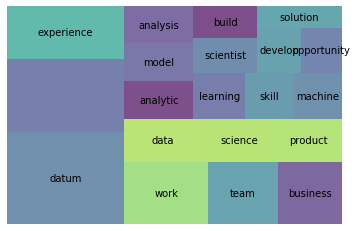

In [86]:
import squarify

# Plot top 20 most common words
top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=top20['pct_total'], label=top20['word'], alpha=0.7)
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [88]:
# Instantiate a TfidfVectorizer instance
tfidf = TfidfVectorizer(stop_words='english', max_features=500)

# fit_transform on the description data
matrix = tfidf.fit_transform(data['description'])

# convert the sparse matrix to a dense matrix and load to a dataframe
tf_df = pd.DataFrame(matrix.todense(), columns=tfidf.get_feature_names())
tf_df.head()

,ability,able,access,achieve,action,actionable,ad,additional,address,advanced,...,working,workplace,works,world,writing,written,www,year,years,youll
0,0.203666,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.0
1,0.036188,0.0,0.0,0.0,0.000000,0.000000,0.0,0.064677,0.0,0.000000,...,0.071622,0.0,0.0,0.08445,0.143608,0.051291,0.0,0.070942,0.00000,0.0
2,0.088682,0.0,0.0,0.0,0.000000,0.150392,0.0,0.000000,0.0,0.105629,...,0.087759,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.0
3,0.000000,0.0,0.0,0.0,0.123066,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.127391,0.00000,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.18375,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [89]:
from sklearn.neighbors import NearestNeighbors

# Instantiate a NearestNeighbors instance
nn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')

# Fit on TF-IDF feature matrix
nn.fit(tf_df)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [90]:
nn.kneighbors([tf_df.iloc[0]])

(array([[0.        , 1.1579797 , 1.1579797 , 1.17637682, 1.18185868]]),
 array([[  0,  42, 138, 325,  79]], dtype=int64))

In [91]:
data['description'][0]

'Job Requirements: Conceptual understanding in Machine Learning models like Naive Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role) Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R Ability to communicate Model findings to both Technical and Non-Technical stake holders Hands on experience in SQL/Hive or similar programming language Must show past work via GitHub, Kaggle or any other published article Master\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field. Apply Now"'

In [92]:
data['description'][42]

"Job Description  5-10 years hands-on experience in forecasting, Machine learning, and/or optimization modeling, and simulation.Working knowledge of predictive modeling and ML tools (scikit, R)Experience with data acquisition tools (e.g. SQL, Apache Spark etc.), large datasets (Hadoop) and data miningProgramming language (Java, scripting language like Python.Good understanding of NLP conceptsHave understanding of machine learning conceptsHave understanding of Hadoop (specifically HIVE/HDFS/Kafka)Fine on programming concepts  pythonStronger skills on image analysis and more experience in Machine Learning / Deep Learning  Qualifications  null  Additional Information  All your information will be kept confidential according to EEO guidelines.'"

In [93]:
# Create new job description
new_description = ['This position is responsible for collecting, analyzing, and creating predictive machine learning models for sports analytics. The candidate for this role will demonstrate knowledge of machine learning, statistical modeling, applied mathematics, as well as abilities in programming in Python or R.']

In [94]:
# Transform on new description
new_vect = tfidf.transform(new_description)

# Run k-nearest neighbors on new description
nn.kneighbors(new_vect.todense())

(array([[1.16415894, 1.16415894, 1.16947844, 1.17489048, 1.17546068]]),
 array([[252, 192,  62,   2, 328]], dtype=int64))

In [95]:
# Explore similar job description
data['description'][192]

"InternshipPosition Description The candidate will work along side data scientists / engineers in the team to work on challenging machine learning problems and explore how state-of-the-art machine learning / deep learning approaches can be applied to the E-commerce domain. Minimum Qualifications Machine learning, algorithm, data structure. Additional Preferred Qualifications Please add text Company Summary The Walmart eCommerce team is rapidly innovating to evolve and define the future state of shopping. As the worlds largest retailer, we are on a mission to help people save money and live better. With the help of some of the brightest minds in technology, merchandising, marketing, supply chain, talent and more, we are reimagining the intersection of digital and physical shopping to help achieve that mission. Position Summary The candidate will work along side data scientists / engineers in the team to work on challenging machine learning problems and explore how state-of-the-art machi

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 